In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl

import time
import sys

In [2]:
class TreeParityMachine:
	def __init__(self, N, K, L):
		self.N = N
		self.K = K
		self.L = L
		self._r()

	def _r(self):
		self.W = np.random.randint(-self.L, self.L + 1, size=(self.K, self.N))
    
	def sample_X(self):
		return np.random.randint(-self.L, self.L + 1, size=(self.K,  self.N))
	
	def forward(self, X):
		self.X = X.reshape((self.K, self.N))
		self.sgn = np.sign((self.W * self.X).sum(axis=1))
		self.y = self.sgn.prod()
		return self.y

	def update(self, y_other, update_rule='hebian'):
		if (self.y == y_other):
			if update_rule == 'hebbian':
				self.hebbian(y_other)
			elif update_rule == 'anti_hebbian':
				self.anti_hebbian(y_other)
			elif update_rule == 'random_walk':
				self.random_walk(y_other)
			else:
				raise Exception("Invalid update rule. Valid update rules are: " + 
				"\'hebbian\', \'anti_hebbian\' and \'random_walk\'.")
			
	def hebbian(self, y_other):
		self.W += self.X * self.y * (self.sgn.reshape((-1, 1)) == self.y) * (self.y == y_other)
		self.W = np.clip(self.W, -self.L, self.L+1)

	def anti_hebbian(self, tau2):
		self.W -= self.X * self.y * (self.sgn.reshape((-1, 1)) == self.y) * (self.y == tau2)
		self.W = np.clip(self.W, -self.L, self.L+1)

	def random_walk(self, tau2):
		self.W -= self.X * (self.sgn.reshape((-1, 1)) == self.y) * (self.y == tau2)
		self.W = np.clip(self.W, -self.L, self.L+1)


In [3]:
def test_sync(k, n, l, update_rules=['hebbian'], echo=False, max_time=float('inf')):

	A = TreeParityMachine(n, k, l)
	B = TreeParityMachine(n, k, l)
	E = TreeParityMachine(n, k, l)

	def sync_score(m1, m2):
		return 1.0 - np.average(1.0 * np.abs(m1.W - m2.W)/(2 * l))

	sync = False 
	updates = 0
	eve_updates = 0 
	scores = [] 
	eve_scores = []

	t1 = time.time()
	while(not sync):
		for update_rule in update_rules:

			X = A.sample_X()

			y_A = A.forward(X) 
			y_B = B.forward(X) 
			y_E = E.forward(X) 
			A.update(y_B, update_rule)
			B.update(y_A, update_rule)
			updates += 1

			if y_A == y_B == y_E:
				E.update(y_A, update_rule)
				eve_updates += 1

			score = sync_score(A, B) 
			scores.append(score)
			score_EA = sync_score(A, E)
			score_EB = sync_score(B, E)
			eve_scores.append((score_EA, score_EB))
			sync = score == 1
			score_format = lambda s: str(int(s * 100))
			if echo:
				sys.stdout.write(f"\rSynchronization(AB, EA, EB) = ({score_format(score)}, {score_format(score_EA)}, {score_format(score_EB)})%   /" \
		     + f"  Updates(AB, EAB)  = ({str(updates)}, {str(eve_updates)})") 


	time_taken = time.time() - t1

	if echo:
		if sync:
			print('\nAlice and Bob are synchronized.')
		if eve_scores[-1][0] == 1:
			print('Eve is also synchornized !!!')
	return {'synced': (A.W == B.W).all(), 'time': time_taken, 'updates': updates, 'eve_updates': eve_updates, 'alice': A, 'bob': B, 'eve': E, 'scores': np.array(scores), 'eve_scores': np.array(eve_scores)}


def plot_res(res):
    scores = res['scores']
    eve_scores= res['eve_scores']

    mpl.plot(scores)
    mpl.plot(eve_scores[:, 0])
    mpl.plot(eve_scores[:, 1])
    plt.xlabel('updates')
    plt.ylabel('sync score')
    plt.legend(['Alice/Bob score', 'Eve/Alice score', 'Eve/Bob score'])
    print('Synced: ' + str(res['synced']))


In [4]:
update_rules = ['hebbian', 'anti_hebbian', 'random_walk']

res = test_sync(k=100, n=300, l=1000, update_rules=update_rules, echo=True, max_time=55)

Synchronization(AB, EA, EB) = (100, 68, 68)%   /  Updates(AB, EAB)  = (1503, 400)
Alice and Bob are synchronized.


Synced: True


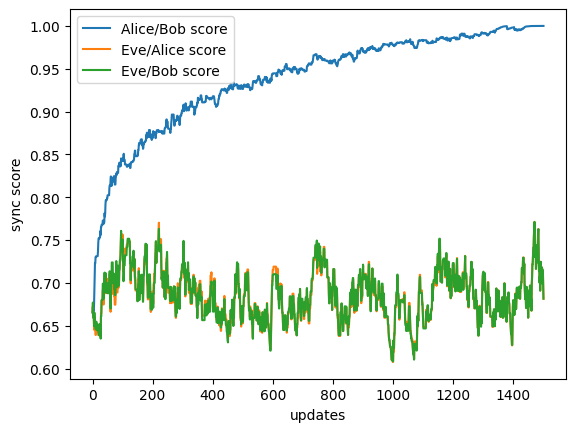

In [5]:
plot_res(res)

In [6]:
res

{'synced': True,
 'time': 0.6746060848236084,
 'updates': 1503,
 'eve_updates': 400,
 'alice': <__main__.TreeParityMachine at 0x7fa69c29f7c0>,
 'bob': <__main__.TreeParityMachine at 0x7fa69c29f3a0>,
 'eve': <__main__.TreeParityMachine at 0x7fa69c29f430>,
 'scores': array([0.66536978, 0.67109243, 0.66694305, ..., 0.9999991 , 1.        ,
        1.        ]),
 'eve_scores': array([[0.66568798, 0.6659229 ],
        [0.67300545, 0.67701538],
        [0.65996475, 0.6594602 ],
        ...,
        [0.71365143, 0.71365233],
        [0.6969077 , 0.6969077 ],
        [0.68156175, 0.68156175]])}